In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '111-efficientnetb6'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'

import os
# os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings('ignore')

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 32,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 11,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 32,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 5,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 11,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-4448f537f295258dbdda5d31f52f1be1fb3b28299050f00020165137'
GCS_2019_PATH = 'gs://kds-809fedd13d0b3052396b2c6de7466d3f45a8b07c98c0412fdba287ed'
GCS_MALIGNANT_PATH = 'gs://kds-8575da0d421fa5470ff18825048c143d29ca3454d015e135a0a3fbcc'

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image):
    image = transform_2(image, DIM=config['HEIGHT'])
    image = data_augment_spatial(image)
    
    if tf.random.uniform([], 0, 1.0, dtype='float32') > .2:
        image = data_augment_rotate(image)

    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    return image

ROT_ = 45.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform_2(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])


def data_augment_spatial(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([], 0, 1.0, dtype='float32')
    
    if p_crop > .5:
        if p_crop > .9:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop > .7:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        else:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .05), int(config['HEIGHT'] * .05)), 
                        max_mask_size=(int(config['HEIGHT'] * .25), int(config['HEIGHT'] * .25))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [10]:
#@title
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0
 
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = data_augment(img)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

In [11]:
#@title
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * config['BATCH_SIZE']
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

# Model

In [12]:
#@title
# Initial bias
#2019 pos = 2.3%
#2018 pos = 1.3%
pos = len(train[train['target'] == 1])
neg = len(train[train['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(train)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [13]:
def model_fn(input_shape=(256, 256, 3)):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(input_shape=input_shape, 
                                    weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)

    model = Model(inputs=input_image, outputs=output)

    opt = optimizers.Adam(learning_rate=0.001)
    loss = losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt, loss=loss,metrics=['AUC'])

    return model

# Training

In [14]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []; history_list = []; oof_pred_last = []
preds = np.zeros((len(test), 1))
preds_last = np.zeros((len(test), 1))

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec' % x for x in idxT])
    # Add external data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2+1) for x in idxT]) # 2019 data
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2) for x in idxT]) # 2018 data
    # Add extra malignant data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % x for x in idxT]) # 2020 data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2+1)+30) for x in idxT]) # 2019 data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2)+30) for x in idxT]) # 2018 data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % (x+15) for x in idxT]) # new data

    np.random.shuffle(TRAINING_FILENAMES)
    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    ct_valid = count_data_items(files_valid)
    ct_test = count_data_items(TEST_FILENAMES)
    VALID_STEPS = config['TTA_STEPS'] * ct_valid/config['BATCH_SIZE']/4/REPLICAS
    TEST_STEPS = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

    model_path_best = f'{MODEL_BASE_PATH}model_{fold}.h5'
    model_path_last = f'{MODEL_BASE_PATH}model_{fold}_last.h5'
    checkpoint = ModelCheckpoint(model_path_best, monitor='val_loss', mode='min', save_best_only=True,
                                 save_weights_only=True, verbose=0)
   
    # TRAIN
    history = model.fit(get_dataset(TRAINING_FILENAMES, augment=True, shuffle=True, repeat=True,
                                    dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']), 
                        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                                                    repeat=False,dim=config['HEIGHT']), 
                        steps_per_epoch=count_data_items(TRAINING_FILENAMES)/config['BATCH_SIZE']//REPLICAS, 
                        callbacks=[checkpoint, get_lr_callback(config['BATCH_SIZE'])], 
                        epochs=config['EPOCHS'], 
                        verbose=2).history
    
    history_list.append(history)

    model.save_weights(model_path_last)
    
    # PREDICT OOF USING TTA (last)
    print('Predicting OOF with TTA (last)...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=True,
                           repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred_last.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'),axis=1))

    # PREDICT TEST USING TTA (last)
    print('Predicting Test with TTA (last)...')
    ds_test = get_dataset(TEST_FILENAMES, labeled=False, return_image_names=False, augment=True,
                          repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds_last[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']
    
    # Load best weights
    model.load_weights(model_path_best)
    
    # PREDICT OOF USING TTA (best)
    print('Predicting OOF with TTA (best)...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=True,
                           repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'),axis=1))
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=config['HEIGHT'],
                           labeled=True, return_image_names=True)
    oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]))
    oof_folds.append(np.ones_like(oof_tar[-1], dtype='int8')*fold)
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=config['HEIGHT'],
                     labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA (best)
    print('Predicting Test with TTA (best)...')
    ds_test = get_dataset(TEST_FILENAMES, labeled=False, return_image_names=False, augment=True,
                          repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1], oof_pred[-1])
    auc_last = roc_auc_score(oof_tar[-1], oof_pred_last[-1])
    oof_val.append(np.max(history['val_auc']))
    print('#### FOLD %i OOF AUC = %.3f, with TTA (best) = %.3f, with TTA (last) = %.3f' % 
          (fold+1, oof_val[-1], auc, auc_last))

INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]
165527552/165527152 [==============================] - 2s 0us/step
Epoch 1/12
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


142/142 - 115s - auc: 0.5791 - loss: 0.3034 - val_auc: 0.3322 - val_loss: 0.1872 - lr: 5.0000e-06
Epoch 2/12
142/142 - 86s - auc: 0.7966 - loss: 0.2421 - val_auc: 0.7524 - val_loss: 0.1734 - lr: 6.8000e-05
Epoch 3/12
142/142 - 86s - auc: 0.8786 - loss: 0.2222 - val_auc: 0.8336 - val_loss: 0.1669 - lr: 1.3100e-04
Epoch 4/12
142/142 - 86s - auc: 0.8940 - loss: 0.2167 - val_auc: 0.8733 - val_loss: 0.1647 - lr: 1.9400e-04
Epoch 5/12
142/142 - 81s - auc: 0.9027 - loss: 0.2118 - val_auc: 0.8536 - val_loss: 0.1736 - lr: 2.5700e-04
Epoch 6/12
142/142 - 81s - auc: 0.9168 - loss: 0.2080 - val_auc: 0.8526 - val_loss: 0.1651 - lr: 3.2000e-04
Epoch 7/12
142/142 - 86s - auc: 0.9275 - loss: 0.1997 - val_auc: 0.8901 - val_loss: 0.1644 - lr: 2.5620e-04
Epoch 8/12
142/142 - 86s - auc: 0.9398 - loss: 0.1954 - val_auc: 0.8598 - val_loss: 0.1638 - lr: 2.0516e-04
Epoch 9/12
142/142 - 81s - auc: 0.9459 - loss: 0.1901 - val_auc: 0.8816 - val_loss: 0.1659 - lr: 1.6433e-04
Epoch 10/12
142/142 - 81s - auc: 0.956

INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]
Epoch 1/12
142/142 - 113s - auc: 0.5343 - loss: 0.3016 - val_auc: 0.5658 - val_loss: 0.1868 - lr: 5.0000e-06
Epoch 2/12
142/142 - 87s - auc: 0.7867 - loss: 0.2431 - val_auc: 0.7279 - val_loss: 0.1745 - lr: 6.8000e-05
Epoch 3/12
142/142 - 87s - auc: 0.8781 - loss: 0.2219 - val_auc: 0.8595 - val_loss: 0.1655 - lr: 1.3100e-04
Epoch 4/12
142/142 - 81s - auc: 0.8974 - loss: 0.2146 - val_auc: 0.8691 - val_loss: 0.1676 - lr: 1.9400e-04
Epoch 5/12
142/142 - 87s - auc: 0.9084 - loss: 0.2117 - val_auc: 0.8669 - val_loss: 0.1641 - lr: 2.5700e-04
Epoch 6/12
142/142 - 87s - auc: 0.9144 - loss: 0.2078 - val_auc: 0.8563 - val_loss: 0.1640 - lr: 3.2000e-04
Epoch 7/12
142/142 - 81s - auc: 0.9317 - loss: 0.1977 - val_auc: 0.8978 - val_loss: 0.1646 - lr: 2.5620e-04
Epoch 8/12
142/142 - 88s - auc: 0.9419 - loss: 0.1931 - val_auc: 0.9030 - val_loss: 0.1623 - lr: 2.0516e-04
Epoch 9/12
142/142 - 89s - auc: 0.9496 - loss: 0.1881 - val_auc

INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]
Epoch 1/12
142/142 - 115s - auc: 0.5611 - loss: 0.3167 - val_auc: 0.4077 - val_loss: 0.1876 - lr: 5.0000e-06
Epoch 2/12
142/142 - 86s - auc: 0.7914 - loss: 0.2414 - val_auc: 0.7637 - val_loss: 0.1733 - lr: 6.8000e-05
Epoch 3/12
142/142 - 88s - auc: 0.8744 - loss: 0.2226 - val_auc: 0.8770 - val_loss: 0.1643 - lr: 1.3100e-04
Epoch 4/12
142/142 - 88s - auc: 0.8960 - loss: 0.2157 - val_auc: 0.8797 - val_loss: 0.1639 - lr: 1.9400e-04
Epoch 5/12
142/142 - 88s - auc: 0.9022 - loss: 0.2123 - val_auc: 0.8993 - val_loss: 0.1607 - lr: 2.5700e-04
Epoch 6/12
142/142 - 82s - auc: 0.9124 - loss: 0.2084 - val_auc: 0.8919 - val_loss: 0.1625 - lr: 3.2000e-04
Epoch 7/12
142/142 - 82s - auc: 0.9280 - loss: 0.1991 - val_auc: 0.8918 - val_loss: 0.1618 - lr: 2.5620e-04
Epoch 8/12
142/142 - 82s - auc: 0.9373 - loss: 0.1954 - val_auc: 0.8909 - val_loss: 0.1619 - lr: 2.0516e-04
Epoch 9/12
142/142 - 82s - auc: 0.9447 - loss: 0.1897 - val_auc

INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]
Epoch 1/12
142/142 - 113s - auc: 0.5767 - loss: 0.2942 - val_auc: 0.5108 - val_loss: 0.1879 - lr: 5.0000e-06
Epoch 2/12
142/142 - 87s - auc: 0.7864 - loss: 0.2437 - val_auc: 0.7663 - val_loss: 0.1715 - lr: 6.8000e-05
Epoch 3/12
142/142 - 87s - auc: 0.8703 - loss: 0.2226 - val_auc: 0.8421 - val_loss: 0.1666 - lr: 1.3100e-04
Epoch 4/12
142/142 - 88s - auc: 0.8876 - loss: 0.2176 - val_auc: 0.8731 - val_loss: 0.1650 - lr: 1.9400e-04
Epoch 5/12
142/142 - 88s - auc: 0.9048 - loss: 0.2106 - val_auc: 0.8895 - val_loss: 0.1625 - lr: 2.5700e-04
Epoch 6/12
142/142 - 88s - auc: 0.9098 - loss: 0.2075 - val_auc: 0.8941 - val_loss: 0.1610 - lr: 3.2000e-04
Epoch 7/12
142/142 - 82s - auc: 0.9268 - loss: 0.2007 - val_auc: 0.9028 - val_loss: 0.1615 - lr: 2.5620e-04
Epoch 8/12
142/142 - 88s - auc: 0.9343 - loss: 0.1956 - val_auc: 0.9088 - val_loss: 0.1601 - lr: 2.0516e-04
Epoch 9/12
142/142 - 82s - auc: 0.9472 - loss: 0.1896 - val_auc

INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.11.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]
Epoch 1/12
142/142 - 111s - auc: 0.5893 - loss: 0.2990 - val_auc: 0.4652 - val_loss: 0.1897 - lr: 5.0000e-06
Epoch 2/12
142/142 - 87s - auc: 0.7883 - loss: 0.2422 - val_auc: 0.7554 - val_loss: 0.1720 - lr: 6.8000e-05
Epoch 3/12
142/142 - 89s - auc: 0.8769 - loss: 0.2241 - val_auc: 0.8422 - val_loss: 0.1658 - lr: 1.3100e-04
Epoch 4/12
142/142 - 88s - auc: 0.8923 - loss: 0.2161 - val_auc: 0.8338 - val_loss: 0.1634 - lr: 1.9400e-04
Epoch 5/12
142/142 - 87s - auc: 0.9026 - loss: 0.2116 - val_auc: 0.8580 - val_loss: 0.1632 - lr: 2.5700e-04
Epoch 6/12
142/142 - 88s - auc: 0.9191 - loss: 0.2067 - val_auc: 0.8818 - val_loss: 0.1615 - lr: 3.2000e-04
Epoch 7/12
142/142 - 88s - auc: 0.9293 - loss: 0.2005 - val_auc: 0.8782 - val_loss: 0.1600 - lr: 2.5620e-04
Epoch 8/12
142/142 - 82s - auc: 0.9377 - loss: 0.1959 - val_auc: 0.8989 - val_loss: 0.1622 - lr: 2.0516e-04
Epoch 9/12
142/142 - 82s - auc: 0.9470 - loss: 0.1902 - val_auc

## Model loss graph

Fold: 1


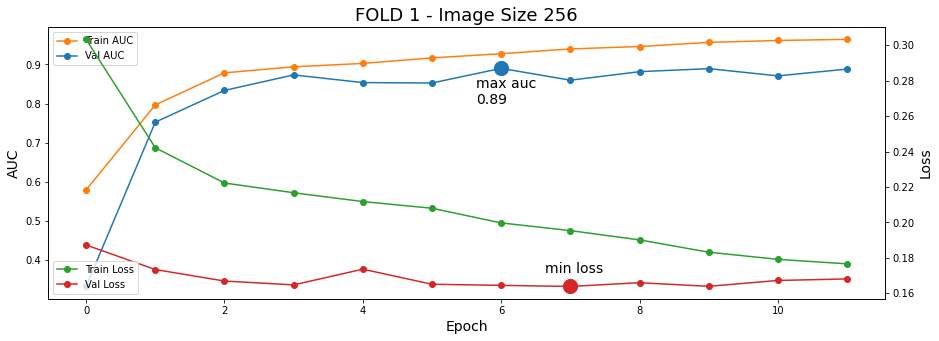

Fold: 2


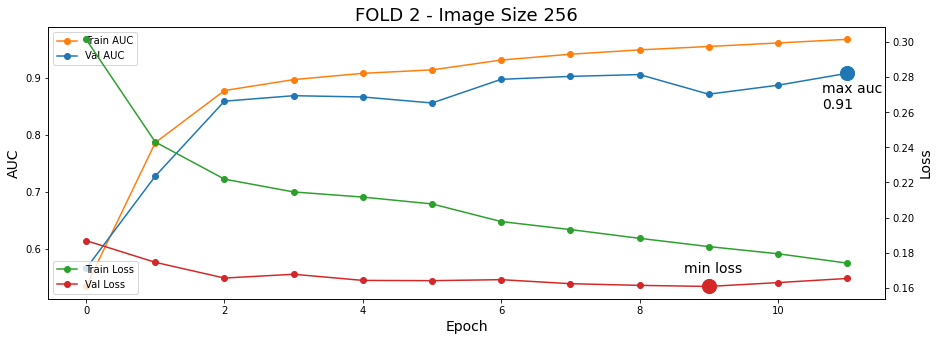

Fold: 3


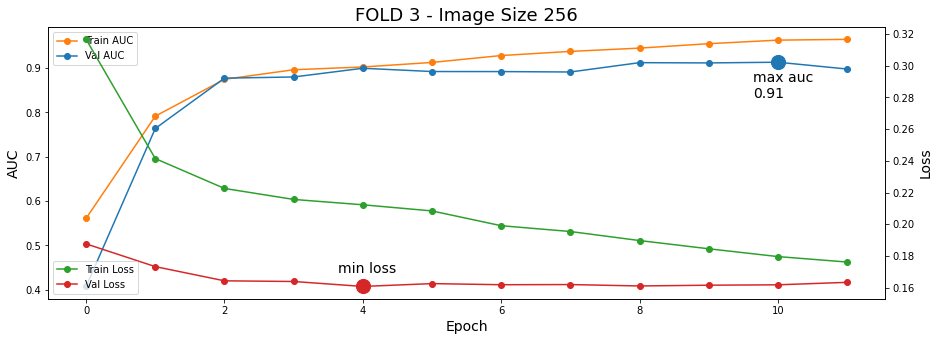

Fold: 4


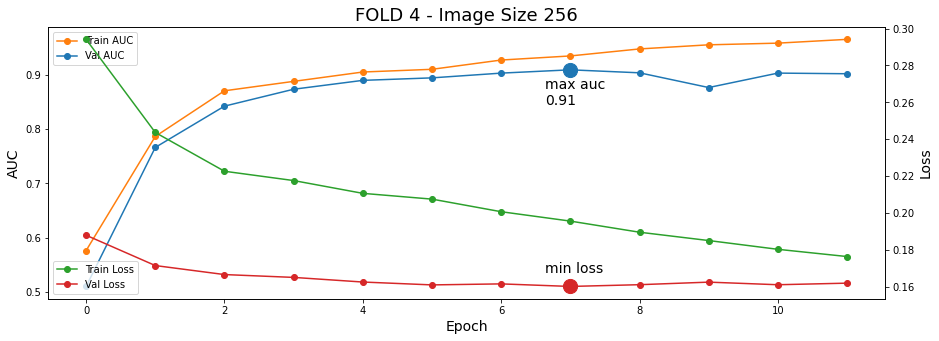

Fold: 5


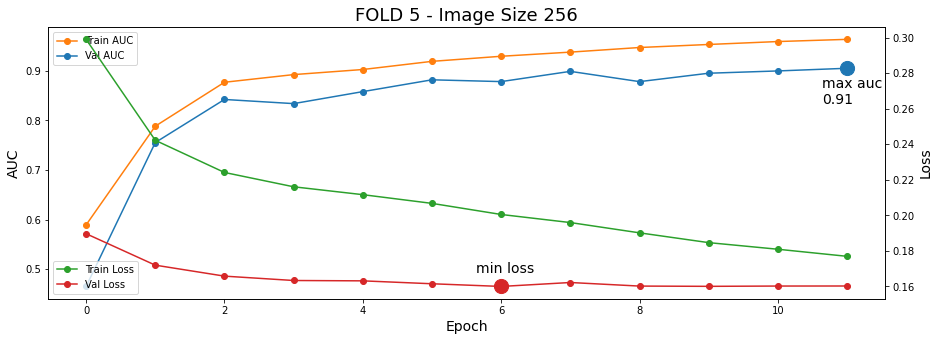

In [15]:
#@title
for n_fold, history in enumerate(history_list):
    print(f'Fold: {n_fold + 1}')
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(config['EPOCHS']), history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(config['EPOCHS']), history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax(history['val_auc'])
    y = np.max(history['val_auc'])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(config['EPOCHS']), history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(config['EPOCHS']), history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'])
    y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('FOLD %i - Image Size %i' % (n_fold+1, config['HEIGHT']), size=18)
    plt.legend(loc=3)
    plt.show()

## Model loss graph aggregated

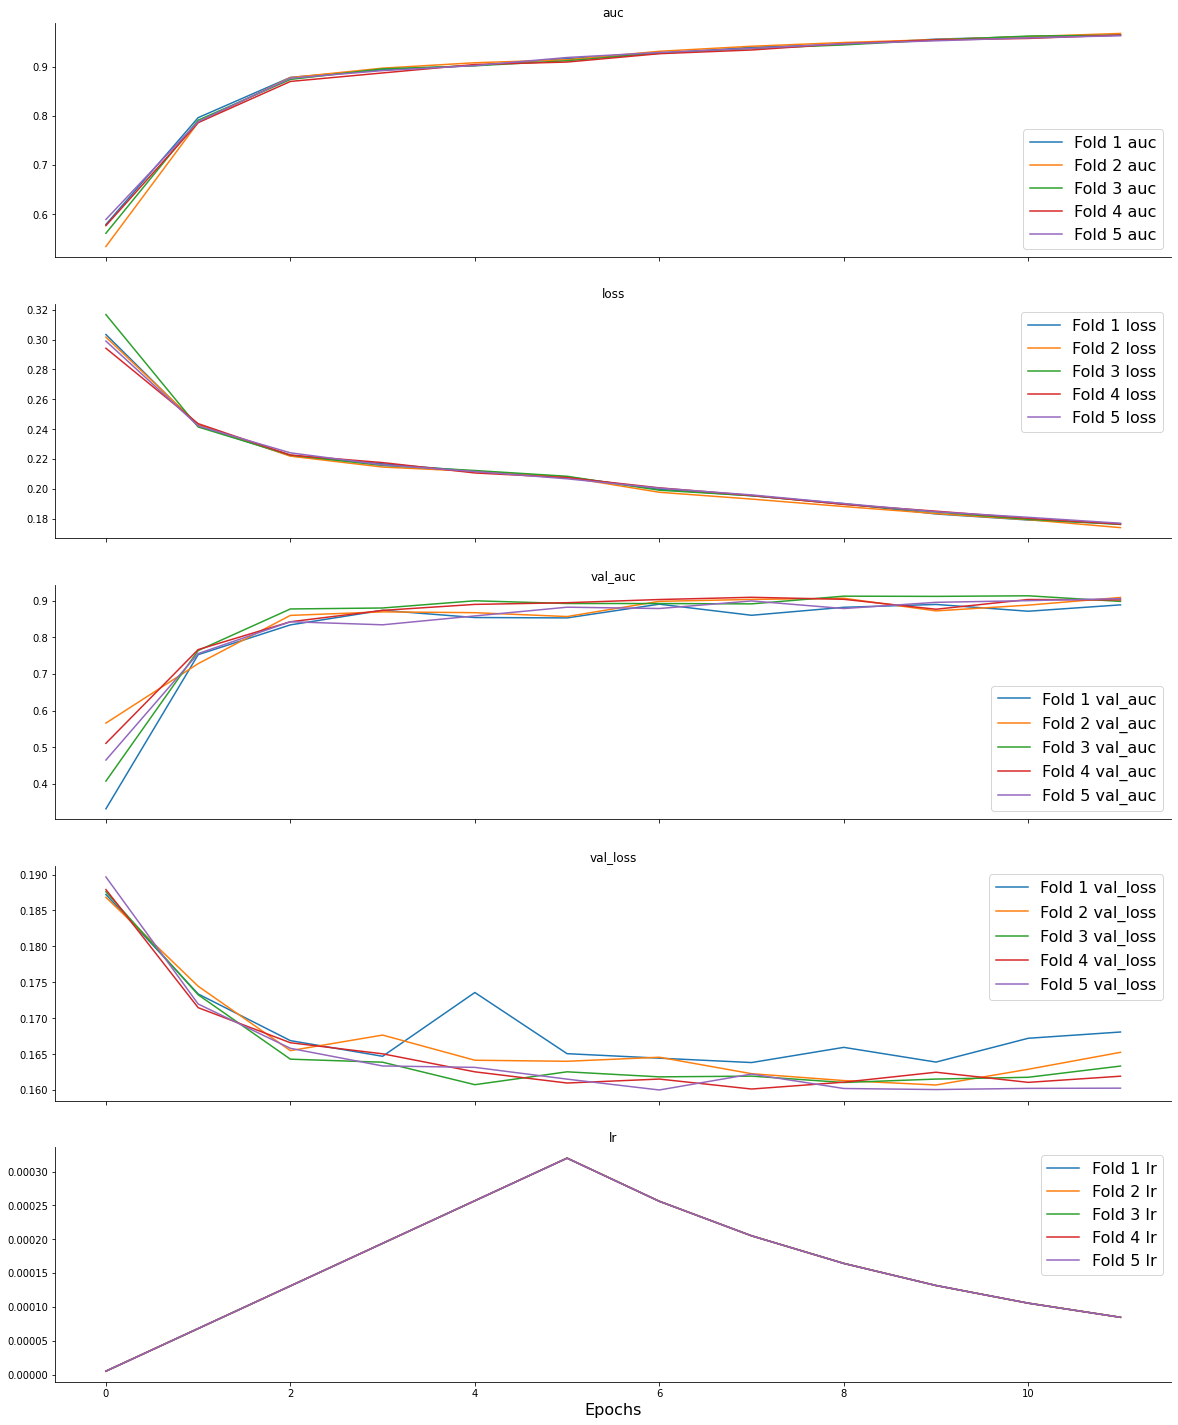

In [16]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [17]:
#@title
# COMPUTE OVERALL OOF AUC (last)
oof = np.concatenate(oof_pred_last)
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true, oof)
print('Overall OOF AUC with TTA (last) = %.3f' % auc)

# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred)
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true, oof)
print('Overall OOF AUC with TTA = %.3f' % auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_name=names, target=true, pred=oof, fold=folds))
df_oof.to_csv('oof.csv', index=False)
df_oof.head()

Overall OOF AUC with TTA (last) = 0.915
Overall OOF AUC with TTA = 0.903


,image_name,target,pred,fold
0,ISIC_2637011,0,0.024139,0
1,ISIC_0076262,0,0.018025,0
2,ISIC_0074268,0,0.019681,0
3,ISIC_0015719,0,0.020974,0
4,ISIC_0082543,0,0.020793,0


# Visualize test predictions

Test predictions 40|10942
Test predictions (last) 90|10892
Top 10 samples


,image_name,target,target_last
9905,ISIC_0052060,0.022391,0.020047
1443,ISIC_0052349,0.023859,0.021080
3120,ISIC_0058510,0.022426,0.022338
4870,ISIC_0073313,0.021116,0.019100
5494,ISIC_0073502,0.023514,0.019905
4537,ISIC_0074618,0.030702,0.028181
4819,ISIC_0076801,0.026549,0.022377
7203,ISIC_0077586,0.031773,0.028997
10897,ISIC_0082004,0.031453,0.028214
5093,ISIC_0082785,0.039069,0.027723


Top 10 positive samples


,image_name,target,target_last
2280,ISIC_0112420,0.676709,0.916134
10750,ISIC_0481105,0.535461,0.810107
7421,ISIC_0539432,0.608229,0.907763
10640,ISIC_1364884,0.810444,0.974808
5350,ISIC_1429763,0.566041,0.895808
1408,ISIC_1593714,0.714614,0.919614
7450,ISIC_1670692,0.591625,0.835753
6029,ISIC_2170268,0.604477,0.894556
1500,ISIC_2481946,0.625331,0.936550
10375,ISIC_2539351,0.506365,0.671825


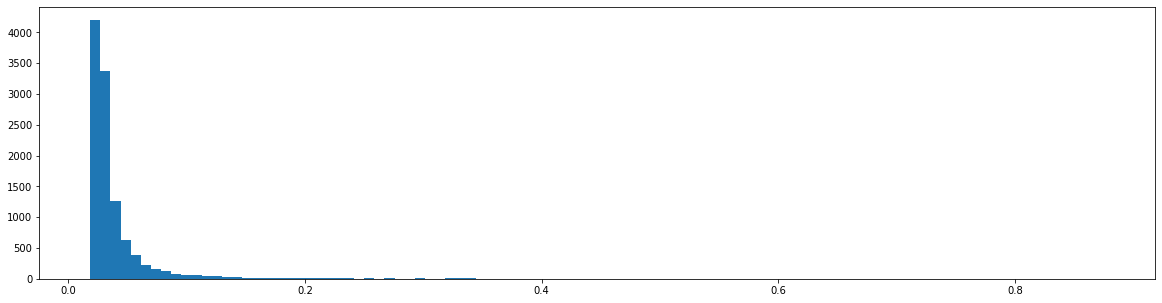

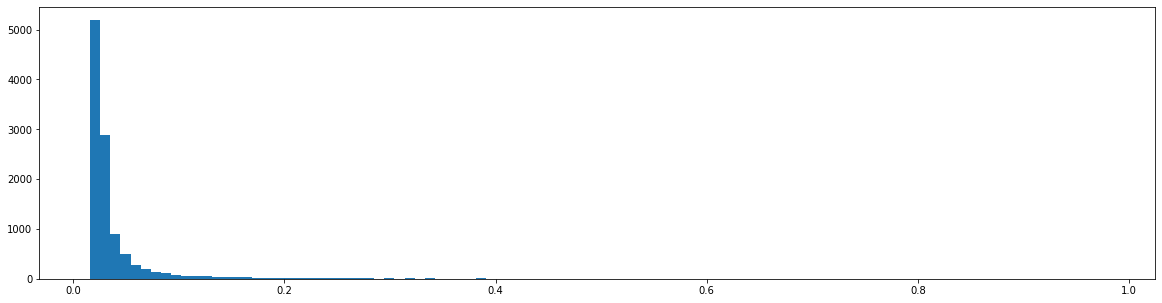

In [18]:
#@title
ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0], target_last=preds_last[:,0]))
submission = submission.sort_values('image_name')

print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")
print(f"Test predictions (last) {len(submission[submission['target_last'] > .5])}|{len(submission[submission['target_last'] <= .5])}")

print('Top 10 samples')
display(submission.head(10))

print('Top 10 positive samples')
display(submission.query('target > .5').head(10))

fig = plt.subplots(figsize=(20, 5))
plt.hist(submission['target'], bins=100)
plt.show()

fig = plt.subplots(figsize=(20, 5))
plt.hist(submission['target_last'], bins=100)
plt.show()

# Test set predictions

In [19]:
#@title
submission['target_blend'] = (submission['target'] * .5) +  (submission['target_last'] * .5)
display(submission.head(10))
display(submission.describe().T)

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend
9905,ISIC_0052060,0.022391,0.020047,0.021219
1443,ISIC_0052349,0.023859,0.021080,0.022470
3120,ISIC_0058510,0.022426,0.022338,0.022382
4870,ISIC_0073313,0.021116,0.019100,0.020108
5494,ISIC_0073502,0.023514,0.019905,0.021710
4537,ISIC_0074618,0.030702,0.028181,0.029441
4819,ISIC_0076801,0.026549,0.022377,0.024463
7203,ISIC_0077586,0.031773,0.028997,0.030385
10897,ISIC_0082004,0.031453,0.028214,0.029834
5093,ISIC_0082785,0.039069,0.027723,0.033396


,count,mean,std,min,25%,50%,75%,max
target,10982.0,0.042305,0.051977,0.018658,0.024911,0.029704,0.039553,0.875774
target_last,10982.0,0.045840,0.078681,0.015870,0.022445,0.025975,0.036234,0.976886
target_blend,10982.0,0.044073,0.064528,0.018008,0.023685,0.027876,0.037974,0.924469
